# Project 3 Industrial Mathematics

In this project we investigate Non-negative Matrix factorization (NMF). 
First we consider some mathematical aspects of the numerical algorithm proposed by Lee and Seung. 
We will apply the algorithm on some simple matrices to investigate how it works and some of its properties.
Secondly, we look at the decomposition of a CryptoPunk image set. We will see how NMF can be used to 
determine the most important features of the set and to reduce the sizes of the images through lossy compression. Lastly, we investigate how the algorithm can be used to denoise images.
Here we also explore how a choice of the decomposition size can result in either overfitting or 
underfitting the reconstructed images.

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import os
import time
import cv2

## Task 1

In this task we will consider some properties of the NMF algorithm to understand how it works and its potential drawbacks and limits. We do this by first investigating some of the properties of the algorithm mathematically, and then test it on the four matrices $A_1$ to $A_4$. By doing this, we will be able to observe the results of multiple instances of the algorithm and the traits that define it. 

We start by intializing the given matrices $A_1$ to $ A_4$ as defined by the assignment:

In [2]:
A_1 = np.array([[1,0],
                [0,1]])

A_2 = np.array([[1,2],
                [1,1],
                [1,2]])

A_3 = np.array([[2,1,1],
                [2,1,1],
                [1,1,2]])

A_4 = np.array([[2,1,0],
                [1,2,3],
                [0,3,3]])

In [3]:
def NMF(V, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    Decompose matrix V in matrices W and H, with d as the number of columns in W and rows in H.
    For each iteration of W and H the frobenius norm between V and the matrix product W @ H is calculated,
    and passed into array for_norm.
    input:
        V: (m,n) input array
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        fro_norm: (maxiter) array
    """

    if seed != 0:
        np.random.seed(seed)

    # Initialize W and H as matrices with random numbers between 0 and 1
    m , n = V.shape
    W = np.random.random(size = (m, d))
    H = np.random.random(size = (d, n))
    
    # Scale initial values
    W = W * np.sqrt(V.mean()/d)
    H = H * np.sqrt(V.mean()/d)

    fro_norm = np.zeros(maxiter)

    # Update W and H
    for i in range(maxiter):
        H = H * (W.T @ V) / (W.T @ W @ H + delta)
        W = W * (V @ H.T) / (W @ H @ H.T + delta)
        fro_norm[i] = np.linalg.norm(V - W@H, ord='fro')

    return W, H, fro_norm

### 1 a)

Our first step is to check for non-negativity in the NMF algorithm.

Assume that all elements in A are non-negative, and that all elements in $H_k$ and $W_k$ > 0. Initialize $(H_0)_{ij} > 0$ and $(W_0)_{ij} > 0$. First iteration is therefore:
$$
(H_1)_{ij} = (H_0)_{ij} * \frac{(W_0^T A)_{ij}}{(W_0^T W_0 H_0)_{ij}}
$$
Since all (ij) elements needs to be bigger than 0 by assumption, multiplicatiting and dividing by elements bigger than 0  $\Rightarrow (H_1)_{ij} > 0$
For $(W_0)_{ij}$ the first iteration will be:
$$
(W_1)_{ij} = (W_0)_{ij} * \frac{(A H_1^T)_{ij}}{(W_0 H_1 H_1^T)_{ij}}
$$
Again multiplying and dividing by elements bigger than zero $\Rightarrow (H_=)_{ij} > 0$.
Now we assume $(H_k)_{ij} > 0, (W_k)_{ij} > 0$. For iteration of the next matrices $(W_{k+1})_{ij} > 0, (W_{k+1}))_{ij} > 0$ we get:
$$
(H_{k+1})_{ij} = (H_k)_{ij} * \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}}
$$
and
$$
(W_{k+1})_{ij} = (W_k)_{ij} * \frac{(A H_{k+1}^T)_{ij}}{(W_k H_{k+1} H_{k+1}^T)_{ij}}
$$
such that we only multiply and divide with positive elements. The first iteration gives non negative elements of the matrices, and the "next" iteration gives the same. By induction it is therefore proved that all iterations $W_k$ and $H_k$ are non-negative.

### 1 b)

We observe that a multiplication of $H_k$ with a matrix of ones results in the following iterations returning the same $H$. Thus $H_{k+1} = H_{k}$.

$\frac{W^T A}{W^T W H}$ matrix of ones $\Rightarrow (\frac{W^T A}{W^T W H})_{ij} = 1$. 
$$
(H_{k+1})_{ij} = (H_k)_{ij} * \frac{(W_k^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} = (H_k)_{ij} * 1 = (H_k)_{ij}
$$
Therefore $H_{k+1} = H_{k}$.

Now we set $H_{k+1} = H_k = H$.
$$
W H = A \\
\Rightarrow W_k H_k = A \\
\Rightarrow W_k^T W_k H_k = W_k^T A 
$$
Calculating elementwise with indices (i,j):
$$
\Rightarrow (H_{k+1})_{ij} * (W_k^T W_k H_k)_{ij}= (H_{k+1})_{ij} * (W^T A)_{ij} $$ \
$$
\Rightarrow (H_{k+1})_{ij} = (H_{k+1})_{ij} * \frac{(W^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} = (H_{k})_{ij} * \frac{(W^T A)_{ij}}{(W_k^T W_k H_k)_{ij}} = (H_{k})_{ij}
$$

Therefore $W H = A$ $ \Rightarrow H_{k+1} = H_k$

### 1 c)

If $H_0$ and $W_0$ both contain only zero elements, then all iterates $H_k$ and $W_k$ will contain only zeroes as well, since their elements $(H_k)_{ij}$ and $(W_k)_{ij}$ will be a multiplication between some finite number and zero. This means that if $H_0$ and $W_0$ are initialized with only zero elements, the iteration will not produce anything interesting.


### 1 d)

The function is implemented above

### 1 e)

In [4]:
W1, H1, norm1 = NMF(A_1,d=2,maxiter=1000)
W2, H2, norm2 = NMF(A_2,d=2,maxiter=1000)

print(f"Frobenius norm of the difference A1-WH: {np.linalg.norm(A_1-W1@H1):.3e}")
print(f"Frobenius norm of the difference A2-WH: {np.linalg.norm(A_2-W2@H2):.3e}")

Frobenius norm of the difference A1-WH: 9.207e-10
Frobenius norm of the difference A2-WH: 1.082e-09


**Comment:** As we can see, the norm is practically zero after $1000$ iterations with orders less than $10^{-8}$. The results appear reasonable given that the two matrices are small and simple, and $d$ is equal to the number of linearly independent columns in the matrices.

### 1 f)

We want to find the rank of matrices $A_3$ and $A_4$. This is done by calculating their eigenvalues.

In [5]:
eig_3 = np.linalg.eig(A_3)
eig_4 = np.linalg.eig(A_4)
print('The eigenvalues of A3 are: ', eig_3[0])
print('The eigenvalues of A3 are: ', eig_4[0])

The eigenvalues of A3 are:  [ 4.00000000e+00  1.00000000e+00 -5.06378553e-16]
The eigenvalues of A3 are:  [-0.75770177  2.09911499  5.65858678]


**Comment:** The last eigenvalue of matrix $A_3$ is near machine accuracy of 0, so we assume it to be zero. Therefore the matrix $A_3$ has rank 2, whereas matrix $A_4$ has rank 3, which means that matrix $A_3$ has two lineraly independent columns, and $A_4$ has three.

### 1 g)

We will lastly plot the frobenius norm as a function of iteration for 3 different values of d, to investigate how d affects the accuracy of the NMF algorithm.

[]

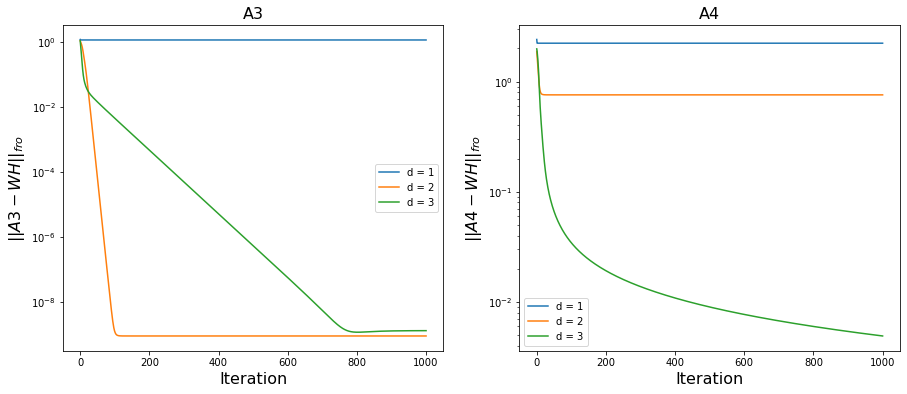

In [6]:
d_list = [1,2,3]
maxiter = 1000
norm_A3 = np.zeros((3, maxiter))
norm_A4 = np.zeros((3, maxiter))
iterator = np.linspace(0, maxiter, maxiter)

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(15, 6))
for i in range(len(d_list)):
    d = d_list[i]
    W_3, H_3, norm_A3[i] = NMF(A_3, d, maxiter=maxiter)
    W_4, H_4, norm_A4[i] = NMF(A_4, d, maxiter=maxiter)
    ax1.semilogy(iterator, norm_A3[i], label = f"d = {d}")
    ax2.semilogy(iterator, norm_A4[i], label = f"d = {d}")
ax1.legend()
ax1.set_title('A3', fontsize = 16)
ax1.set_xlabel('Iteration', fontsize = 16)
ax1.set_ylabel('$||A3 - WH||_{fro}$', fontsize = 16)
ax2.legend()
ax2.set_title('A4', fontsize = 16)
ax2.set_xlabel('Iteration', fontsize = 16)
ax2.set_ylabel('$||A4 - WH||_{fro}$', fontsize = 16)
plt.plot()

**Comment:** It is clear that the error tends to decrease with increasing $d$, until the alorithm reaches a local/global minima to where it stays constant. Interestingly, for matrix $A_3$ the convergence is often faster for $d=2$ than $d=3$ (this we have seen after testing multiple times), and it converges to a lower error. This is because, as we saw from 1 f) that $A_3$ only has two eigenvalues meaning that a decomposition into two coloumns and rows for $W$ and $H$ respectively is the optimal choice for this matrix. A larger value of $d$ only results in reduntant information for the NMF to process.

## Task 2

We will now begin investigating the results of using the NMF-algorithm on the CryptoPunks dataset.

We start by loading the pictures from the dataset and then checking to see if they contain the right amount of information such as colour channels and opacity channels.

In [7]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)


(24, 24, 4, 500)


In [8]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams


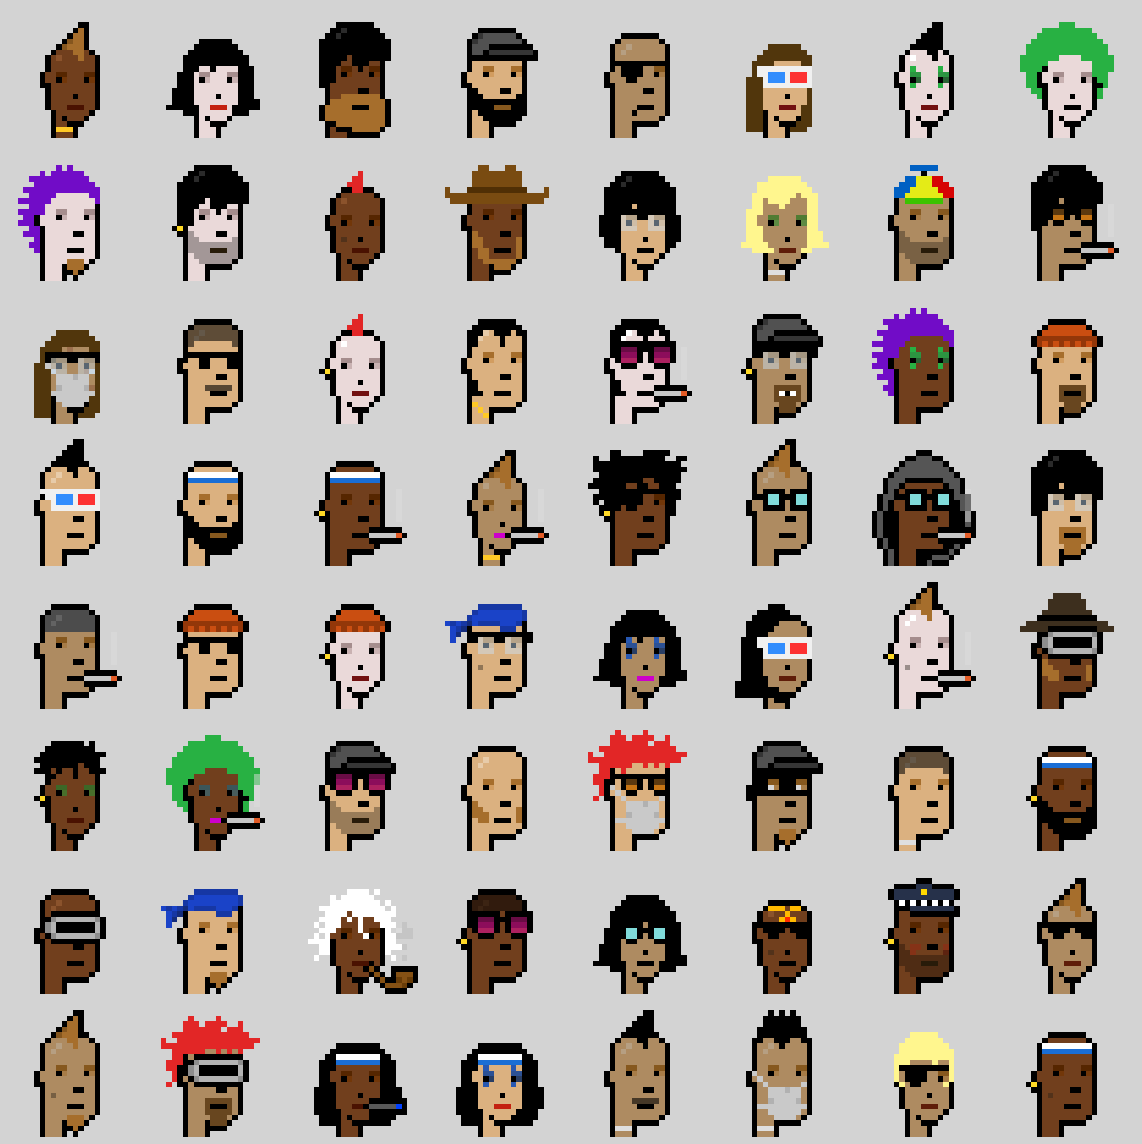

In [9]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

In [10]:
# Split the images into opacity and rgb channels
faces_opacity = faces[:,:,3,:]
faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape

# Clever reshape "trick". This is the matrix we will apply the NMF to
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)

### 2 b)

Calculating and plotting the mean of all the faces in the dataset.

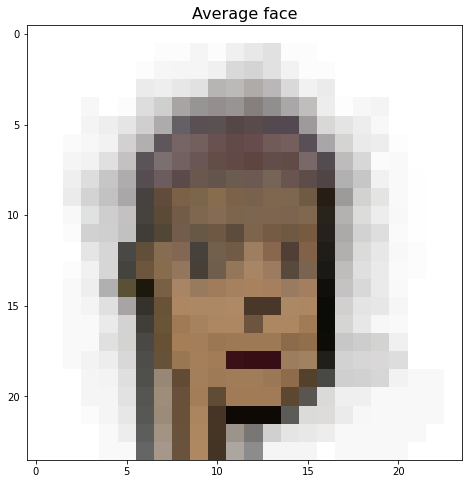

In [11]:
mean_f=np.mean(faces[:,:,:,:],axis=-1)
plt.figure(1, figsize = (8,8))
plt.imshow(mean_f[:,:,:])
plt.title('Average face', fontsize = 16)
plt.show()

**Comment:** We see that the results yield a face with no discernable features. It is clear that the common feature for all the CryptoPunks is the shape of the face, as well as the general area for eyes, nose and lips. We also see some noise around the head, which must be a result of the different vectors (accessories) of the punks. 
We can from the plotted image observe that there are many pixels that has no opacity around the head, specifically in the corners. This must be a result of the fact that none of the image has anything in those areas. This gives us valuable information of the rank of the matrix containing this image. 
If $A$ is a matrix, then $rank(A)$ is equal to the number of leading variables in the general solution of $A\textbf{x}=\textbf{0}$. Because of this, the rank of a matrix cannot exeed the amount of zero columns in the matrix. We know that the matrices are $24\times24$, and we can from the mean image see that there are $3$ zero columns, so the rank of the matrix must be lower or equal to 21. 

### 2 c)

We will now calculate the NMF of the 3 color channels using $d = 64$. We decompose the color channels into $W_{RGB}$ and $H_{RGB}$ vectors.

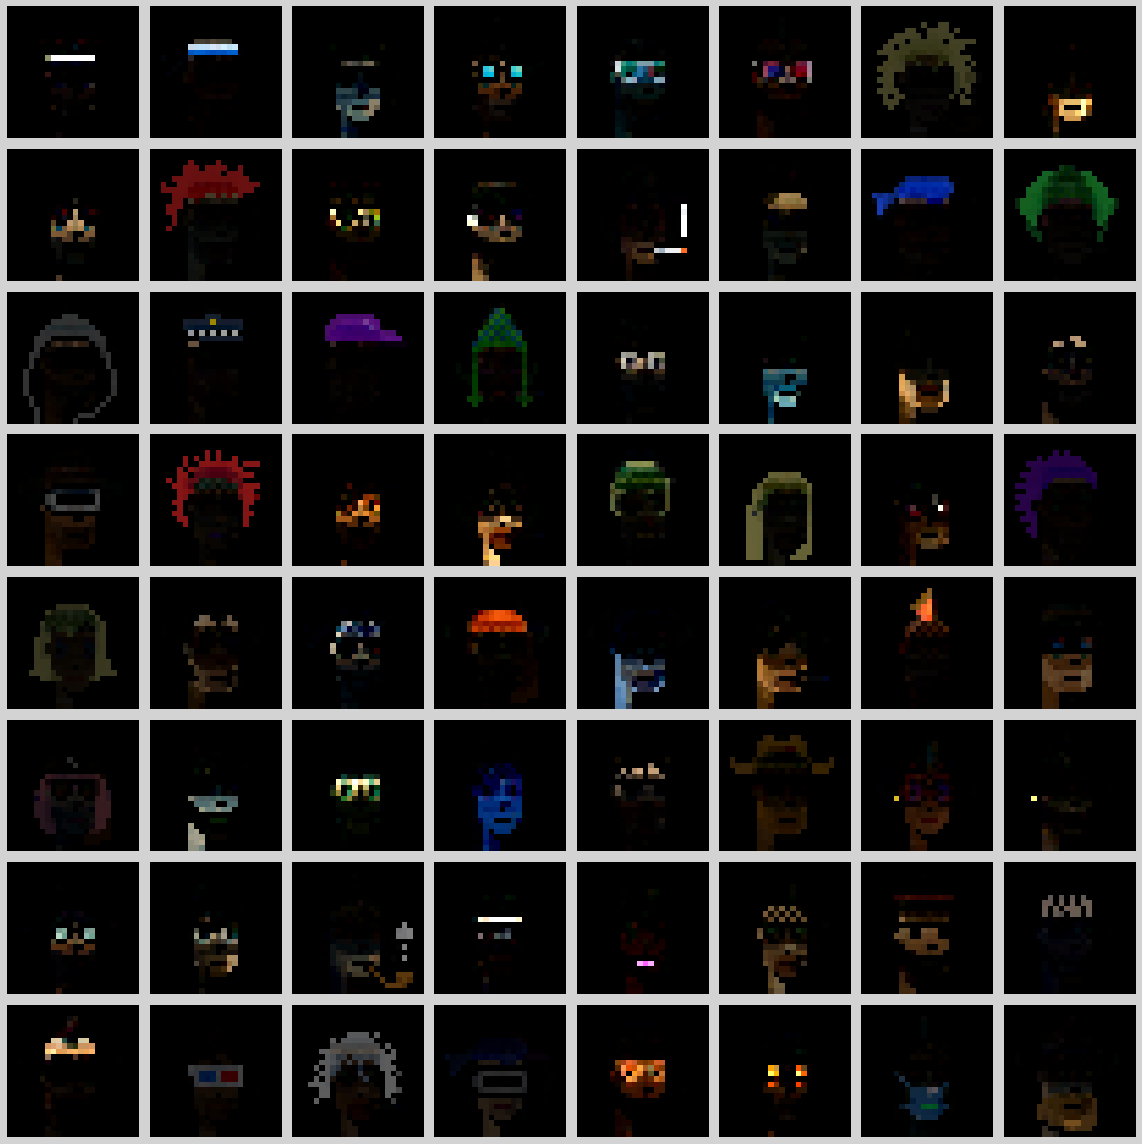

In [12]:
W_RGB, H_RGB, norm_fro_RGB = NMF(faces_reshaped, d=64)
W_reshaped = np.clip(np.reshape(W_RGB, (24,24,3,64)), 0, 1)
plotimgs(W_reshaped, 8)

**Comment:** Applying our function MNF to the images "splits" the faces into traits that multiple faces have, for example a red hat or a cigarette. The NMF seems therefore to capture common features of the different faces. When we have experimented with smaller d we get fewer traits, which will reduce the accuracy when the traits are combined to reconstruct the images. When we used bigger d the computation time increases, which is to be expected, whereas the accuracy improves, allthough not by very much.

### 2 d)

We will now reconstruct the images using the matrix product of $W_{RGB}$ and $H_{RGB}$ calculated in the previous task.

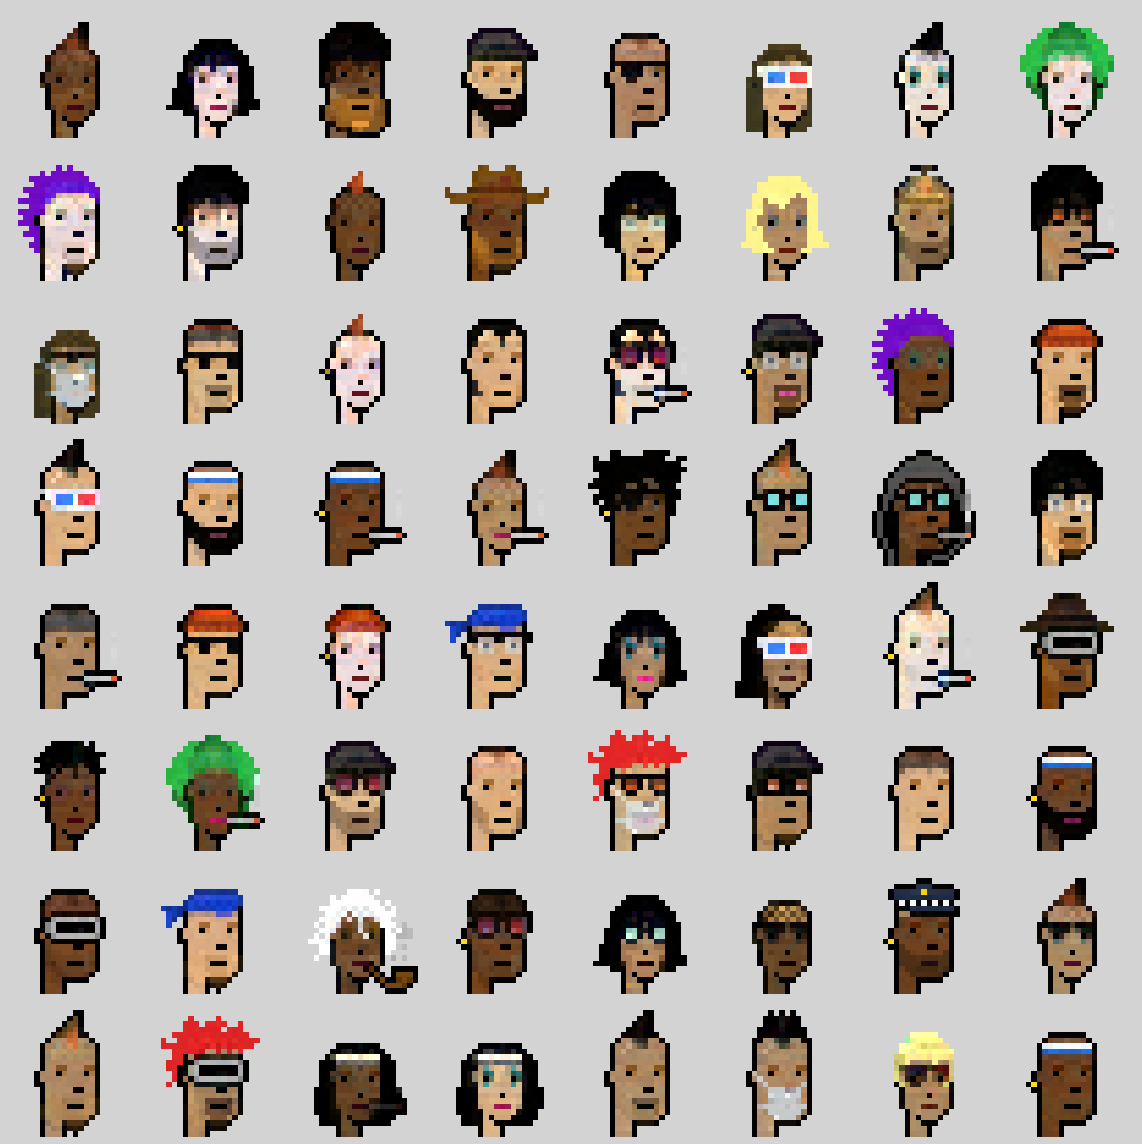

In [13]:
Image_RGB = (W_RGB@H_RGB).reshape(24, 24, 3, 500)
faces_opacity_reshaped = faces_opacity.reshape(24,24,1,500)

# Set all values below 0 to 0, and set all values above 1 to 1, and rejoin the reconstructed image with the opacity channel
Image_clipped = np.clip(np.append(Image_RGB, faces_opacity_reshaped, axis = 2),0,1 ) 
plotimgs(Image_clipped)

**Comment:** We observe that most of the images are well constructed, as almost all of the images are indeed recognizable and most of the faces keep thir individual looks, traits and accessories. One thing we do observe is noise on all of the reconstructed faces: their skin tones are not consistent, with multiple pixels deviating somewhat from the original skintones. Furthermore, we observe that there is a significant loss of sharper and unqiue colors. Specifically, once bright and sharp eye-paint has faded significantly, unique eye, nose and lip-color fade alot as well. But the most significant is the unique skin tones. While the "normal" skin colors such as white, fair, and darker stay mostly consistent, we have observed that if the dataset has contained a green zombie, the zombie has totally lost the green skin tone. 
It seems that the most average qualities gets well reconstructed as well as individual vectors, but unique colors in general areas such as the eyes, nose, mouth and skin tones gets lost. 

### 2 e)

We will now plot the error as a function of iteration step for three different values of $d$. Matrix $A$ represents the images before decomposition.

[]

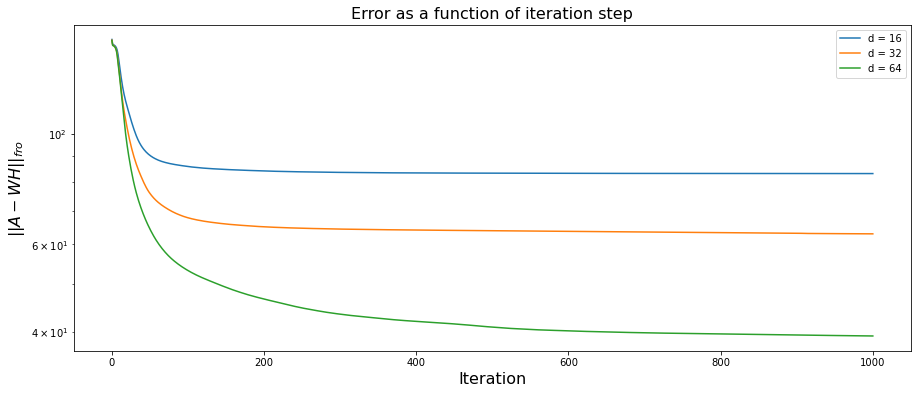

In [14]:
d_list = [16,32,64]
maxiter = 1000
iterator = np.linspace(0, maxiter, maxiter)
fig, ax1 = plt.subplots(1, 1 , figsize=(15, 6))
for i in range(len(d_list)):
    d = d_list[i]
    W, H, norm_A = NMF(faces_reshaped, d, maxiter=maxiter)
    ax1.semilogy(iterator, norm_A, label = f"d = {d}")
ax1.legend()
ax1.set_title('Error as a function of iteration step', fontsize = 16)
ax1.set_xlabel('Iteration', fontsize = 16)
ax1.set_ylabel('$||A - WH||_{fro}$', fontsize = 16)
plt.plot()

**Comment:** The iteration seems to converge for all values of $d$, but the error converges to quite a lot lower value when $d$ increases. It seems reasonable that the accuracy improves when we use higher value for $d$ since the decomposition contain more information then.

### 2 f)

We will now perform the same calculation and plot the norm, this time with even more values of $d$.

[]

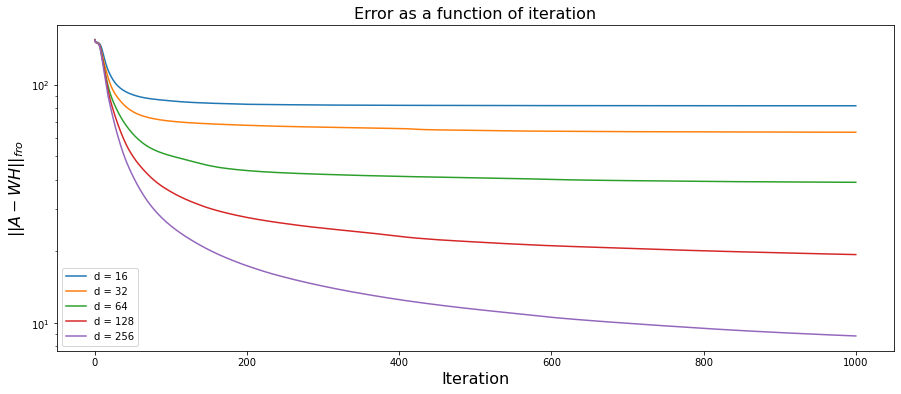

In [15]:
d_list = [16, 32, 64, 128, 256]
maxiter = 1000
iterator = np.linspace(0, maxiter, maxiter)
fig, ax1 = plt.subplots(1, 1 , figsize=(15, 6))
for i in range(len(d_list)):
    d = d_list[i]
    W, H, norm_A = NMF(faces_reshaped, d, maxiter=maxiter)
    ax1.semilogy(iterator, norm_A, label = f"d = {d}")
ax1.legend()
ax1.set_title('Error as a function of iteration', fontsize = 16)
ax1.set_xlabel('Iteration', fontsize = 16)
ax1.set_ylabel('$||A - WH||_{fro}$', fontsize = 16)
plt.plot()

**Comment:** The error keeps on decreasing when $d$ is increased, and the iterations converges to some value for all values of $d$. This is probably because even though the traits that "stand out" in the faces, for example the hair, or hat, is accurately represented, whereas skin color and other traits discussed in task 2 d) will be more and more accurately represented in the reconstruction of the images, the higher d is.

The drawback with using high value for $d$ is that it is more computationally expensive, and it stores more data.

## Task 3

In this task we will examine the denoising properties of the NMF algorithm. To do this, we'll artifically create "noicy" images and put them though the NMF algorithm. Then we'll observe the output and how these images compare. Specifically, we'll examine the columns of W to see the atributes of the "vectors" and the noice in them, and them compare different values of $d$ in the NMF algorithm.

In [16]:
def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces



In [17]:
def NMF_noisy(V, V_noisless, d, delta = 1e-9, maxiter = 1000, seed = 0):
    """
    Decompose matrix V, which in this case is an image with noise added to it, in matrices W and H, 
    with d as the number of columns in W and rows in H. For each iteration of W and H the frobenius
    norm between V_noisless and the matrix product W @ H is calculated, and passed into for_norm.
    input:
        V: (m,n) input array, image with added noise
        V_noisless: (m,n) input array, image without added noise
        d: integer, Number of components we want to decompose V into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
    output:
        W: (m,d) array
        H: (d,n) array
        fro_norm: (maxiter) array
    """

    if seed != 0:
        np.random.seed(seed)

    # Initialize W and H as matrices with random numbers between 0 and 1
    m , n = V.shape
    W = np.random.random(size = (m, d))
    H = np.random.random(size = (d, n))
    
    # Scale initial values
    W = W * np.sqrt(V.mean()/d)
    H = H * np.sqrt(V.mean()/d)

    fro_norm = np.zeros(maxiter)

    # Update W and H
    for i in range(maxiter):
        H = H * (W.T @ V) / (W.T @ W @ H + delta)
        W = W * (V @ H.T) / (W @ H @ H.T + delta)
        fro_norm[i] = np.linalg.norm(V_noisless - W@H, ord='fro')

    return W, H, fro_norm

### 3 a)

42.15243749348766


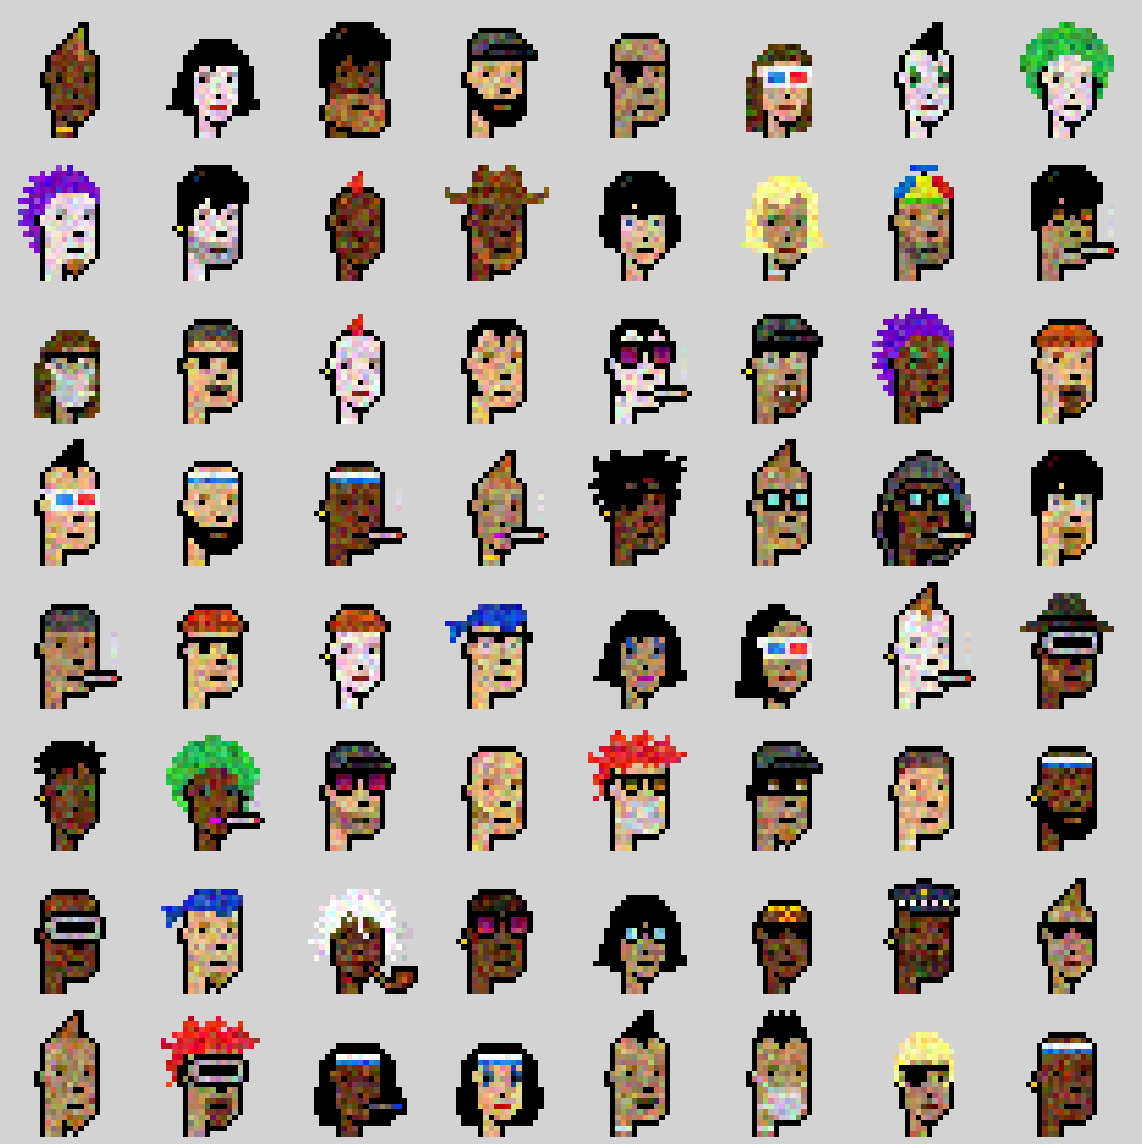

In [18]:
noisy_faces = add_noise(faces_reshaped)

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped)
print(noise_residual)

# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity
plotimgs(noisy_faces_with_opacity)

### 3 b)

We will now decomcose the noisy images created above using NMF, as before.

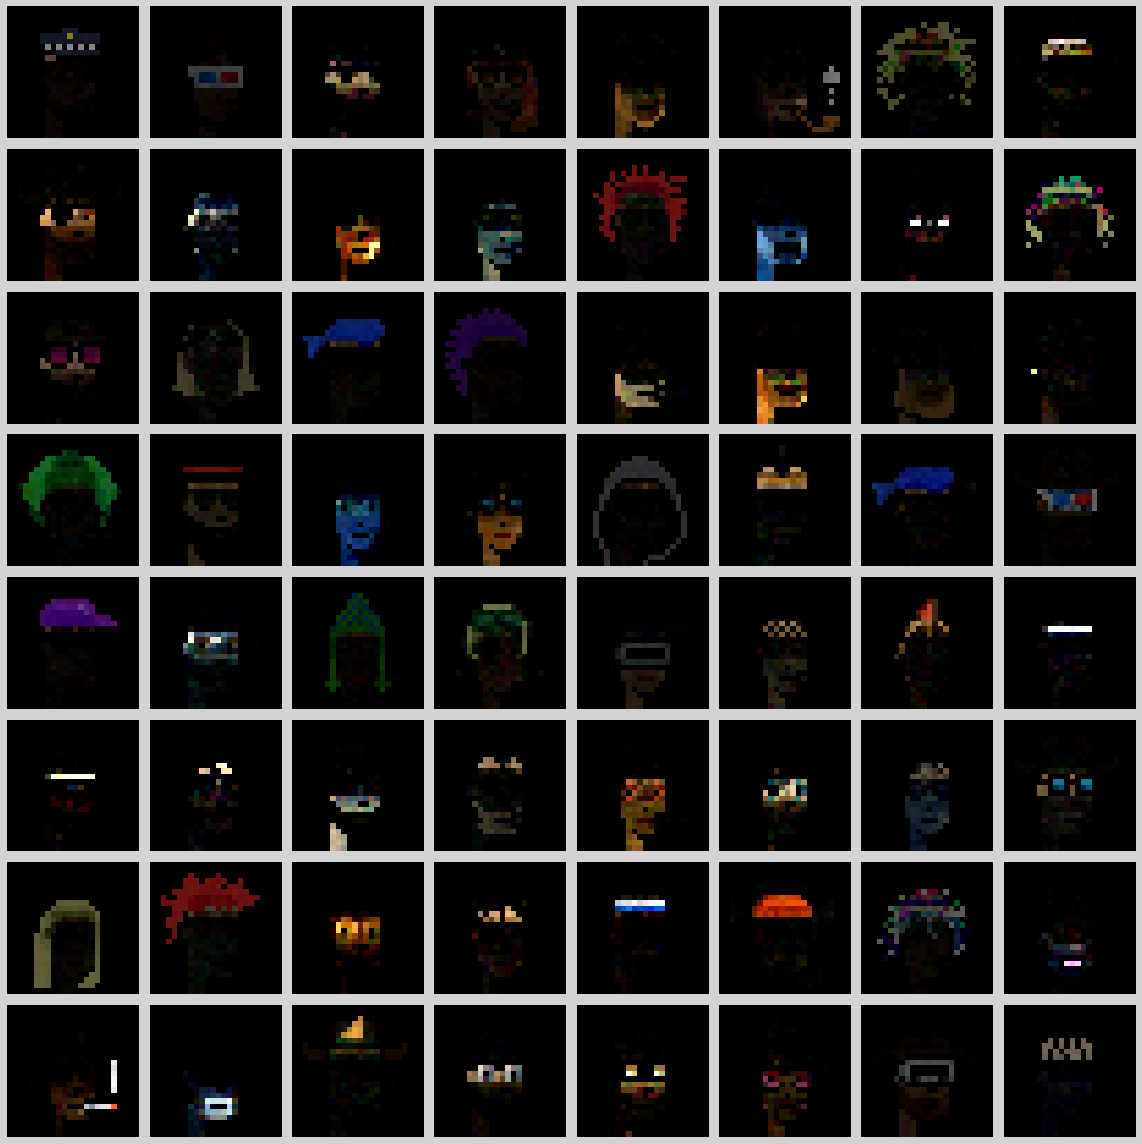

In [19]:
d = 64
N = 500
noisy_faces_opacityless = noisy_faces_with_opacity[:,:,:3,:]
noisy_faces_reshaped = noisy_faces_opacityless.reshape(np.prod(noisy_faces_opacityless.shape)//N, N)
W_noisy, H_noisy, norm_noisy = NMF(noisy_faces_reshaped, d)
W_noisy_reshaped = np.clip( W_noisy.reshape((24,24,3,64)), 0, 1)
plotimgs(W_noisy_reshaped)

**Comment:** The decomposed vectors are less noisy than the noisy images we started with. They do not seem to be more noisy than the vectors calculated from the noisless images in task 2. This implies that NMF can be used to reduce the noise in the images. 

We will now reconstruct the images.

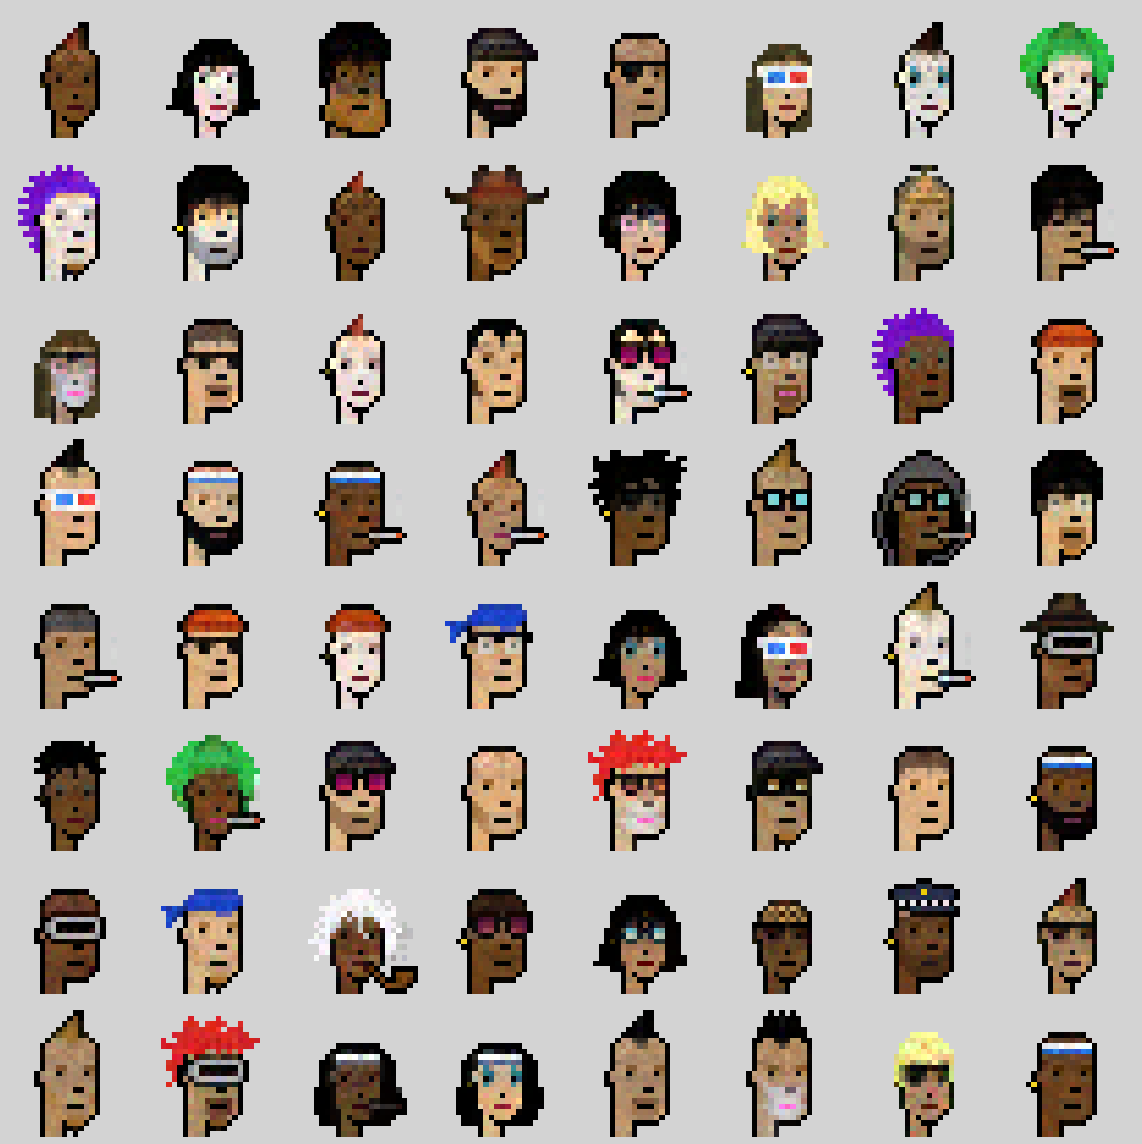

In [20]:
A = (W_noisy@H_noisy).reshape(24, 24, 3, 500)
faces_noisy_NMF = np.copy(noisy_faces_with_opacity)
faces_noisy_NMF[:,:,:3,:] = A
faces_noisy_NMF[:,:,3,:] = noisy_faces_with_opacity[:,:,3,:]
faces_noisy_NMF = np.clip(faces_noisy_NMF, 0, 1)
plotimgs(faces_noisy_NMF)

**Comment:** The reconstructed images are, as expected after investigating the decomposed vector $W$, less noisy than the images we started with.

### 3 c)

We will now, as in the previous tasks see how the error of the reconstructed image changes (hopefully improves) as a function of iteration for multiple values for $d$. 

[]

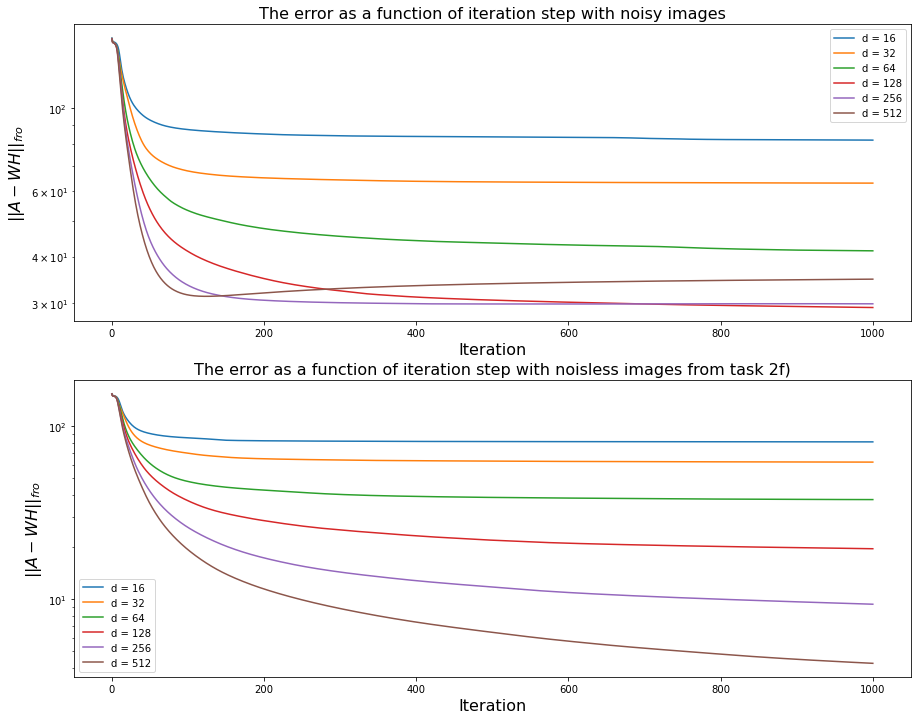

In [21]:
noisy_faces_reshaped = noisy_faces_opacityless.reshape(np.prod(noisy_faces_opacityless.shape)//N, N)
d_list = [16,32,64, 128, 256, 512]
maxiter = 1000
iterator = np.linspace(0, maxiter, maxiter)
fig, axs = plt.subplots(2, figsize=(15, 12))
for i in range(len(d_list)):
    d = d_list[i]
    W, H, norm_A = NMF_noisy(noisy_faces_reshaped, faces_reshaped, d, maxiter=maxiter)
    W, H, norm_2f = NMF(faces_reshaped, d, maxiter=maxiter)
    axs[0].semilogy(iterator, norm_A, label = f"d = {d}")
    axs[1].semilogy(iterator, norm_2f, label = f"d = {d}")
axs[0].legend()
axs[0].set_title('The error as a function of iteration step with noisy images', fontsize = 16)
axs[0].set_xlabel('Iteration', fontsize = 16)
axs[0].set_ylabel('$||A - WH||_{fro}$', fontsize = 16)
axs[1].legend()
axs[1].set_title('The error as a function of iteration step with noisless images from task 2f)', fontsize = 16)
axs[1].set_xlabel('Iteration', fontsize = 16)
axs[1].set_ylabel('$||A - WH||_{fro}$', fontsize = 16)
plt.plot()

**Comment:** For low values of $d$ both figures show that the reconstructions underfits the data contained in $A$, as $W$ and $H$ do not carry enough information to give good recreations of the images. 
From the figures it is evident that the noisy images has a threshold for where an increase in $d$ results in worse reconstructions. This is contrary to the results we saw from 2f where an increase in $d$ resulted in the reconstructions having less error compared with the noisless images. When NMF is applied to the noisy images an increase in $d$ will at some point overfit the dataset, such that the reconstructions contains more noise than a lower $d$. As seen in the figure for the noisy images, at some point above $d=128$, the reconstruction gives a larger error. This is where the NMF "interprets" the noise as valuable data. 

To identify more accurately the threshold of $d$ in the noisy images we ran the test again, but this time for values of $d \in [128, 256]$. We chose $128$ and $256$ as upper and lower bound respectively as it appeared from the figure that the smallest error lied somewhere between these values.

Beneath we have plotted the error of the reconstructed images for five values of $d$.

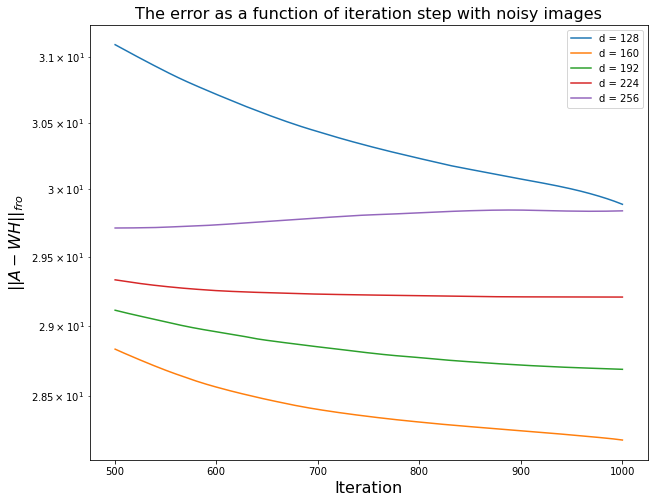

In [22]:
noisy_faces_reshaped = noisy_faces_opacityless.reshape(np.prod(noisy_faces_opacityless.shape)//N, N)
d_list = [128, 160, 192, 224, 256]
maxiter = 1000
iterator = np.linspace(0, maxiter, maxiter)
fig, axs = plt.subplots(1, figsize=(10, 8))
for i in range(len(d_list)):
    d = d_list[i]
    W, H, norm_A = NMF_noisy(noisy_faces_reshaped, faces_reshaped, d, maxiter=maxiter)
    W, H, norm_2f = NMF(faces_reshaped, d, maxiter=maxiter)
    axs.semilogy(iterator[-500:], norm_A[-500:], label = f"d = {d}")
axs.legend()
axs.set_title('The error as a function of iteration step with noisy images', fontsize = 16)
axs.set_xlabel('Iteration', fontsize = 16)
axs.set_ylabel('$||A - WH||_{fro}$', fontsize = 16)
plt.show()

**Comment:** It appears as though a value of $d$ somewhere in the range between $160$ and $190$ provides a reconstruction with the least amount of error. We tried to do additional tests for values of $d$ in between this range, but it did not give any valuable results. The results were varying and it appeared that there wasn't a unique $d$ that resulted in the lowest error of reconstruction. The cause of this might be due to the randomness of the NMF, especially in the initialization process of $W$ and $H$.

## Conclusion

In this project we have examined the NMF algorithm and many of its qualities. It has (lossy) compression capabilities which is very useful in saving large amounts of data, at the cost of some lost information in the matrices. The smaller the W and H matrices are, the more compressed the data becomes, at the cost of less accurate data, as we can see in the task 2f. Furthermore, we can see that the NMF has denoising capabilities from our testing thoughout task $3$. The vectors (accessories in the case of Crypto-punks) becomes less noisy and therefore the resulting reconstructions will be more accurate. As expected, the larger the dimentions of the W and H - matrices are, the more accurate the reconstruction becomes compared to the non-noicy images, but only up to a certain point. For our dataset, we see that when is $d > 190$ the method becomes overfitted, and even more so for $d=512$, which makes our choise of compression dimentions quite important when running the NMF when encountering noice in the dataset.